# Civic Engagement with Data Science

---

Alexander Poon  
PyTennessee 2019  
February 10, 2019

## Hello, PyTennessee

* Background in Public Policy and Education
* Director of Analytics at Tennessee Department of Education
* Aspiring Data Scientist and Python hobbyist

## Motivation

![](images/turnout.png)

[[The Tennessean](https://www.tennessean.com/story/news/2017/12/11/tennessee-voter-registration-cooper-dickerson-project-register/941325001/), December 2017]

![](images/turnout2.png)

[[Pew Research Center](http://www.pewresearch.org/fact-tank/2018/05/21/u-s-voter-turnout-trails-most-developed-countries/), May 2018]

<img src="images/countries.png" style="height:525px">

[[Pew Research Center](http://www.pewresearch.org/fact-tank/2018/05/21/u-s-voter-turnout-trails-most-developed-countries/), May 2018]

## This Project

**What (state) legislation should I pay attention to?**

Preliminaries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from os import environ
from pyopenstates import *

%matplotlib inline

pd.options.display.max_colwidth = 1000

set_api_key(os.environ['OPENSTATES_KEY'])

## The Data

**OpenStates** provides comprehensive information pertaining to state legislators and legislation, including bill text, topics, sponsors, progress through committees, amendments, vote tallies and votes by individual legislators.

![](images/archive.png)

Pull data from the OpenStates API:

In [ ]:
from pyopenstates import *

set_api_key('') # Get key here: https://openstates.org/api/register/

bills = pd.DataFrame(search_bills(state='tn'))

In [3]:
bills = pd.read_csv('../data/bills.csv')

# Remove the 'Amends TCA Title x, Chapter y' from bill titles
bills['title'].replace(to_replace=' - Amends.+$', value='', regex=True, inplace=True)

In [4]:
bills.head(2)

,bill_id,session,subjects,title,sponsors
0,SB 107,110,Government Reform,"Sunset Laws - As enacted, extends the Tennessee life and health insurance guaranty association five years to June 30, 2022.",Bell; Faison
1,HB 228,110,Government Reform,"Sunset Laws - As enacted, extends the Tennessee life and health insurance guaranty association five years to June 30, 2022.",Faison; Bell


## The problem

In [5]:
len(bills)

20089

This represents the four legislative sessions from 2011-2018 (each legislative session runs two years).

## This Project

**What (state) legislation should I pay attention to?**

This might include legislation that:
- pertains to local issues in the city/town/county where I live
- pertains to issues I care about
- is introduced by my Representative/Senator

`pyopenstates` can identify my legislators:

In [6]:
my_legislators = [i.get('last_name') 
                  for i in locate_legislators(36.103565, -86.760322)]

print(my_legislators)

['Powell', 'Dickerson']


<center>

<img src="images/powell.jpg">

Rep. Jason Powell

<img src="images/dickerson.jpg">

Sen. Steven Dickerson

</center>

Tag legislation introducted by my legislators:

In [7]:
bills['my_legislators'] = bills['sponsors'].str.contains('|'.join(my_legislators)) \
    .fillna(False) \
    .astype(int)

Tag legislation pertaining to my county/city/town:

In [8]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='me')

location = geolocator.reverse((36.103565, -86.760322))

my_city, my_county = [location.raw.get('address').get(i)
                      for i in ['city', 'county']]

print(my_city + ', ' + my_county)

Nashville-Davidson, Davidson County


In [9]:
if my_city == "Nashville-Davidson":
    my_city = "Nashville"

# Tag legislation mentioning my city or county from location
bills['my_city_county'] = bills['title'].str.contains(my_city + '|' + my_county) \
    .astype(int)

Tag legislation pertaining to subjects I'm interested in:

(What are possible subjects?)

In [10]:
# Get a list of possible subjects
bills['subjects'].str.get_dummies('; ') \
    .agg(sum) \
    .sort_values(ascending = False)

Legal Issues                            2776
Education                               2684
Budget, Spending, and Taxes             1881
Health                                  1599
Municipal and County Issues             1474
Transportation                          1366
Crime                                   1023
Drugs                                   1017
Government Reform                        959
Legislative Affairs                      935
Federal, State, and Local Relations      876
Labor and Employment                     822
Business and Consumers                   717
Housing and Property                     641
Family and Children Issues               641
Commerce                                 591
Campaign Finance and Election Issues     485
Insurance                                481
State Agencies                           474
Judiciary                                468
Environmental                            396
Guns                                     336
Other     

Tag legislation pertaining to subjects I'm interested in:

In [11]:
my_subjects = ['Education']

bills['my_subjects'] = bills['subjects'].str.contains('|'.join(my_subjects)) \
    .fillna(False) \
    .astype(int)

In [12]:
pd.options.display.max_colwidth = 50

In [13]:
bills.head(2)

,bill_id,session,subjects,title,sponsors,my_legislators,my_city_county,my_subjects
0,SB 107,110,Government Reform,"Sunset Laws - As enacted, extends the Tennesse...",Bell; Faison,0,0,0
1,HB 228,110,Government Reform,"Sunset Laws - As enacted, extends the Tennesse...",Faison; Bell,0,0,0


## How a Bill Becomes a Law

In Tennessee, a bill goes through the following [steps](http://www.capitol.tn.gov/about/billtolaw.html) (roughly) to become law:

* Introduced
* Passed on First Consideration
* Passed on Second Consideration
* Referred to Committee(s)
* Placed on Calendar for Third Consideration
    * On Third Consideration, opened for debate and amendment
* Passed on Third Consideration
* Reconcile Senate and House versions
* Signed by Governor or allowed to become law without signature

Pull actions from `OpenStates`:

In [ ]:
actions = pd.DataFrame()

for s, bill in zip(bills['session'], bills['bill_id']):
    actions = pd.concat(
        [actions, pd.DataFrame(
            get_bill(state='tn', term=s, bill_id=bill).get('actions')
        )]
    )

In [14]:
actions = pd.read_csv('../data/actions.csv')

actions.drop_duplicates(['action', 'actor', 'date', 'session', 'bill_id'], inplace=True)
actions['action'].fillna('', inplace=True)

We can observe whether bills make it past each step:

In [15]:
actions.head(10)

,action,actor,session,bill_id,type,ayes,nays
0,Filed for introduction,upper,110,SB 107,bill:reading:1; bill:introduced,NaN,NaN
1,"Introduced, Passed on First Consideration",upper,110,SB 107,bill:introduced,NaN,NaN
2,Filed for intro.,lower,110,SB 107,bill:reading:1; bill:introduced,NaN,NaN
3,"Passed on Second Consideration, refer to Senat...",upper,110,SB 107,other,NaN,NaN
4,"Intro., P1C.",lower,110,SB 107,bill:introduced,NaN,NaN
5,"P2C, ref. to Government Operations Committee",lower,110,SB 107,committee:referred,NaN,NaN
6,Placed on Senate Government Operations Committ...,upper,110,SB 107,other,NaN,NaN
7,"Recommended for passage, refer to Senate Calen...",upper,110,SB 107,other,NaN,NaN
8,Placed on Senate Consent Calendar 2 calendar f...,upper,110,SB 107,other,NaN,NaN
9,Placed on cal. Government Operations Committee...,lower,110,SB 107,other,NaN,NaN


We can observe whether bills make it past each step:

In [16]:
def search_actions(strings):
    """Search actions meeting one of a list of patterns. Strings passed as a list
     are concatenated and used as a regex.

    Returns a DataFrame with bills passing stage specified by string.
    """
    pattern = '|'.join(strings)

    return actions[actions.action.str.contains(pattern)] \
        .loc[:, ['session', 'bill_id']] \
        .drop_duplicates()

Identify the relevant major steps:

In [17]:
intro = search_actions(['Filed for introduction', 'Filed for intro.']) \
    .assign(introduced = 1)

first = search_actions(['Passed on First Consideration', 'P1C']) \
    .assign(first = 1)

second = search_actions(['Passed on Second Consideration', 'P2C']) \
    .assign(second = 1)

committee = search_actions(['H. Placed on Regular Calendar',
                            'H. Placed on Consent Calendar',
                            'Placed on Senate Consent Calendar',
                            'Placed on Senate Regular Calendar']) \
    .assign(committee = 1)

chamber = search_actions(['Passed H.', 'Passed Senate', 'Passed S.']) \
    .assign(chamber = 1)

law = search_actions(['Signed by Governor', 
                      'Returned by Governor without signature']) \
    .assign(law = 1)

How many bills make it past each step?

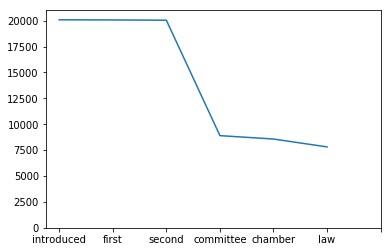

In [18]:
bills = bills \
    .merge(intro, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(first, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(second, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(committee, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(chamber, how='left', on=['session', 'bill_id'], validate='1:1') \
    .merge(law, how='left', on=['session', 'bill_id'], validate='1:1')
    
bills.loc[:, ['introduced', 'first', 'second', 'committee', 'chamber', 'law']] \
    .sum(axis = 0) \
    .plot(xticks=range(7), ylim=(0, 21000))

What do vote margins (yes votes - no votes) look like once bills get past committee?

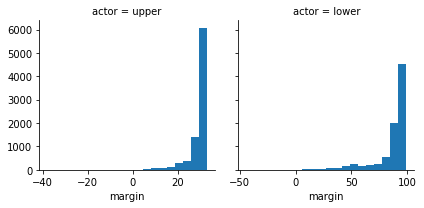

In [19]:
margin = actions.query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine='python') \
    .assign(margin = actions['ayes'] - actions['nays'])

g = sns.FacetGrid(margin, col="actor", sharex=False)
g = g.map(plt.hist, "margin", bins=20)

Once past committee, many bills are uncontroversial (pass by an all-0 vote). I'll also tag uncontroversial bills so I can deprioritize these.

In [20]:
actions['uncontroversial'] = pd.Series(actions['nays'] <= 1).astype(int)

uncontroversial = actions \
    .query('action.str.contains("Failed to pass H.|Failed to pass Senate|Passed H.|Passed Senate|Passed S.")', engine='python') \
    .query('actor == "upper" & bill_id.str.contains("SB") | actor == "lower" & bill_id.str.contains("HB")', engine='python') \
    .groupby(['session', 'bill_id']) \
    .agg({'uncontroversial': 'min'}) \
    .reset_index(drop=False)

bills = bills.merge(uncontroversial, how='left', on=['session', 'bill_id'], validate='1:1')

bills['uncontroversial'].fillna(0, inplace=True)
bills['committee'].fillna(0, inplace=True)

# This Project

**What (state) legislation should I pay attention to?**

This might include legislation that:
- pertains to local issues in the city/town/county where I live
- pertains to issues I care about
- is introduced by my Representative/Senator

and might not include legislation that:

- is uncontroversial (e.g., probably going to pass unanimously)
- has no chance of passing (e.g.: not even going to a vote)

![](images/venn1.png)

![](images/venn2.png)

Of course, we can identify how bills fare retrospectively.

It would be helpful to know (or make an informed guess at) whether bills will go to a vote and/or be uncontroversial as they are introduced so that one might be able to influence legislation by calling legislators, etc.

I use **machine learning** to predict these outcomes.

## The Idea

We know which bills have gone to a vote/been uncontroversial in the past.

I use information (sponsors, topics, **text**) about bills that have gone to a vote/been uncontroversial in the past to predict which bills will go to a vote/be uncontroversial in the future.

## Future bills?

To mimic prediction, I build models using the 107-109th sessions and treat bills from the 110th as 'future bills'.

In [21]:
bills['session'].value_counts()

110    5485
109    5357
108    5204
107    4043
Name: session, dtype: int64

I can then evaluate predictions against what really happened:

| Session  |  ID   |    Prediction   |  Outcome |
|----------|-------|-----------------|----------|
|    110   | HB 10 |    Pass   |     Pass     |
|    110   | HB 11 |    Pass   |    Not Pass  |
|    110   | HB 12 | Not Pass  |    Not Pass  |
|    110   | HB 13 |    Pass   |     Pass     |
|    110   | HB 14 |    Pass   |    Not Pass  |
|    110   |   .   | . | . |
|    110   |   .   | . | . |
|    110   |   .   | . | . |

## Natural Language Processing

From [Wikipedia](https://en.wikipedia.org/wiki/Natural-language_processing):

[A] field of computer science, artificial intelligence concerned with the interactions between computers and human (natural) languages, and, in particular, concerned with **programming computers to fruitfully process large natural language data**.

I use NLP to preprocess and create a numerical representation of text for maching learning.

## A Sample Title

Students - As enacted, requires a student, during the student's high school career, to take a United States civics test.

## Preprocessing Text

I do some preprocessing by running my text through the [spaCy](https://spacy.io/) [annotator](https://demos.explosion.ai/displacy/), which identifies:

- (Word) Tokens
- Parts of speech (nouns, verbs, adjectives, etc.)
- Named entities (United States)
- Lemmas (taught, teaching, teaches -> teach; teachers -> teacher)

![](images/annotation.png)

Annotating a sample piece of text with spaCy:

In [22]:
import spacy

nlp = spacy.load('en')

doc = nlp("As enacted, requires a student, during the student's high school career, to take a United States civics test.")

pd.DataFrame(
    [(n.text, n.lemma_, n.pos_) for n in doc], columns=['token', 'lemma', 'pos']
)

,token,lemma,pos
0,As,as,ADP
1,enacted,enact,VERB
2,",",",",PUNCT
3,requires,require,VERB
4,a,a,DET
5,student,student,NOUN
6,",",",",PUNCT
7,during,during,ADP
8,the,the,DET
9,student,student,NOUN


Annotating text at scale with spaCy:

In [ ]:
tokens = []

for doc in nlp.pipe(bills['title'], batch_size=50):
    tokens.append([(n.text, n.lemma_, n.pos_) for n in doc])
    
annotation_df = pd.concat(
    [pd.DataFrame(tokens[i], columns = ['token', 'lemma', 'pos'])
         for i in range(len(tokens))]
)

In [23]:
tokens = []

for doc in nlp.pipe(bills['title'], batch_size=50):
    tokens.append([(n.text, n.lemma_, n.pos_) for n in doc])

annotation_df = pd.concat(
    [pd.DataFrame(tokens[i], columns = ['token', 'lemma', 'pos'])
        .assign(bill = i)
     for i in range(len(tokens))]
) \
    .reset_index()

In [24]:
annotation_df = annotation_df[['bill', 'index', 'token', 'lemma', 'pos']]

For my application, I keep certain parts of speech, replace tokens with their lemmas, and drop stop words:

In [25]:
from nltk.corpus import stopwords

# Drop and modify tokens depending of part of speech
# https://spacy.io/api/annotation#pos-tagging
annotation_df = annotation_df[annotation_df['pos'].isin(['NOUN', 'VERB', 'PROPN'])]

# Drop anything with nonword characters
annotation_df = annotation_df[~annotation_df['token'].str.contains("\\W|[0-9]")]

# Drop stopwords
annotation_df = annotation_df[~annotation_df['token'].isin(stopwords.words('english'))]

In [26]:
preprocess = pd.Series(
    [' '.join(annotation_df[annotation_df['bill'] == i]['lemma']) for i in range(len(bills))]
)

## A Term Frequency Matrix

One way to quantitatively represent text: create a matrix where each row represents one bill, and each column represents one token. Each value is the number of times a token appears in a bill:

| ID | abandon |...| require | student | high | school | career | take | United | States | civics | test |...| zoning |
|------|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| HB10 | 0 |...| 1 | 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |...| 0 |
| HB11 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
| HB12 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |

This is a **bag of words** representation of a text document.

## A TF-IDF Matrix

I take this one step further, by calculating **T**erm **F**requency-**I**nverse **D**ocument **F**requency. [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) indicates which tokens show up frequently in one document (TF) while downweighting tokens that show up frequently across all documents (IDF).

For a corpus with N documents, the TF-IDF score for token *t* and document *d* is:

$$TFIDF_{(t, d)} = \#\:of\:times\:t\:appears\:in\:d\:*\: log \frac{\#\:of\:documents}{ \#\:of\:documents\:with\:t}$$

## A TF-IDF Matrix

| ID | abandon |...| require | student | high | school | career | take | United | States | civics | test |...| zoning |
|------|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| HB10 | 0 |...|0.089|0.553|0.268|0.151|0.365|0.246|0.272|0.272|0.419|0.274|...| 0 |
| HB11 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
| HB12 | 0 |...| 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |...| 0 |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |
|   .  | . |...| . | . | . | . | . | . | . | . | . | . |...| . |

Think of this as ~ highlighting important terms in a document.

I can do this with `TfidfVectorizer`:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(min_df=10, ngram_range=(1, 3))

X_tfidf = tf.fit_transform(preprocess)

A TF-IDF representation of text will be the input to my machine learning model.

Split my dataset into a **test set** consisting of the most recent session and a **training set** consisting of all prior sets.

In [28]:
bills['session'].value_counts()

110    5485
109    5357
108    5204
107    4043
Name: session, dtype: int64

In [29]:
train_count = sum(bills['session'] != 110)

X_train = X_tfidf[:train_count]
X_test = X_tfidf[train_count:]

Likewise, split the outcomes into training and test components.

In [30]:
Y_train_vote = bills['committee'][:train_count]
Y_test_vote = bills['committee'][train_count:]

Y_train_uncontroversial = bills['uncontroversial'][:train_count]
Y_test_uncontroversial = bills['uncontroversial'][train_count:]

## To recap

I am trying to predict whether a bill will:

1. pass committees/go to a vote  
2. be uncontroversial

based on the presence of certain words/phrases in the Title field.

## Why might this work?

* The presence of certain words/phrases reliably predicts something about a bill's outcome.

## Why might this not work?

* Tendencies of bill outcomes change over time
    * Turnover in legislators AND new legislators have different tendencies than previous legislators
    * Legislators want to do the opposite of what they did previously
    * Bills need 'momentum' in order to pass
* New bills deal with different topics than old bills

## In machine learning parlance

- **Logistic regression** with **elastic net regularization**.
- **Grid search** to iterate over values of the regularization parameter and the tradeoff between the $L_1$ and $L_2$ normed penalties
- Resample during training with **5-fold cross validation**.

## In English

I am asking the algorithm to identify a relationship between inputs (text) and outcomes **that generalizes as well as possible to new data**.

Building a model to predict whether a bill goes to a vote:

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'l1_ratio': np.arange(0, 1, 0.2)
}

elastic_net = GridSearchCV(
    SGDClassifier(loss="log", max_iter=250), params, cv=5
)

elastic_net_vote = elastic_net.fit(X_train, Y_train_vote)

## Evaluating classification predictions

About 44 percent of bills pass all committees and make it to a vote. This means I could achieve ~56% accuracy just by predicting 'no vote' for every bill.

I want my classification accuracy to be meaningfully above 56%.

In [32]:
bills['committee'].value_counts()

0.0    11188
1.0     8901
Name: committee, dtype: int64

Predict on the test set and check accuracy:

In [33]:
from sklearn.metrics import accuracy_score

predict_vote = elastic_net_vote.predict(X_test).astype(int)

accuracy_score(predict_vote, Y_test_vote)

0.9456700091157703

Repeat to predict uncontroversial bills:

In [34]:
bills['uncontroversial'].value_counts()

0.0    13245
1.0     6844
Name: uncontroversial, dtype: int64

In [35]:
elastic_net_uncontroversial = elastic_net.fit(X_train, Y_train_uncontroversial)

predict_uncontroversial = elastic_net_uncontroversial.predict(X_test).astype(int)

accuracy_score(predict_uncontroversial, Y_test_uncontroversial)

0.9279854147675478

An answer to "What legislation should I pay attention to?" might look like the following:

| title | my_legislators | my_city_county | my_subjects | predict_marginal |
|-------|----------------|----------------|-------------|------------------|
|School Transportation - As introduced, places restrictions ... | 1 | 0 | 1 | 1 |
|Education, Higher - As introduced, requires state institutions ... | 0 | 0 | 1 | 1 |
|Education - As introduced, creates a tuition assistance ... | 0 | 0 | 1 | 1 |
|Alcoholic Beverages - As enacted, authorizes The Avenue ... | 1 | 1 | 0 | 0 |
|Board of Regents - As introduced, clarifies the number ... | 1 | 0 | 1 | 0 |

## What next?

Finding as many reasons as possible that a person be interested in a piece of legislation:

- pertains to local issues in their city/town/county
- pertains to issues they care about
- is introduced by their Representative/Senator
- is marginal/not uncontroversial
- **contains search terms of interest**
- **others?**

Then, build something that:

- Notifies people as legislation is introduced that meets these criteria
- Provides something actionable that users can do: call/write their legislator, key committee members, etc.
- Updates on the progression of legislation

## Thanks!

* GitHub: [alexander-poon/legisPy](https://github.com/alexander-poon/legisPy)
* Email: [alexander.poon@pm.me](mailto:alexander.poon@pm.me)
* NashDev: [alexanderpoon]()
* Data Nerds: Tuesday mornings 8-10 am @ Belmont